In [142]:
!python -V

Python 3.10.12


In [143]:
import pandas as pd

In [144]:
import pickle

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

In [146]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [147]:
df = pd.read_parquet('/local/repo/mlops/yellow_tripdata_2023-01.parquet')
len(df.columns)

19

In [148]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df['duration'].std()

np.float64(42.59435124195458)

In [149]:
total_count = len(df)
filtered_df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
filtered_count = len(filtered_df)
fraction_kept = filtered_count / total_count
percentage_kept = fraction_kept * 100
print(f"Total records: {total_count:,}")
print(f"Records after filtering: {filtered_count:,}")
print(f"Fraction kept: {fraction_kept:.4f}")
print(f"Percentage kept: {percentage_kept:.2f}%")

df = df[(df.duration >= 1) & (df.duration <= 60)]
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
num_columns = X_train.shape[1]
print(num_columns)

Total records: 3,066,766
Records after filtering: 3,009,173
Fraction kept: 0.9812
Percentage kept: 98.12%
516


In [150]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658405475663145

/tmp/ipykernel_1288678/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1288678/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


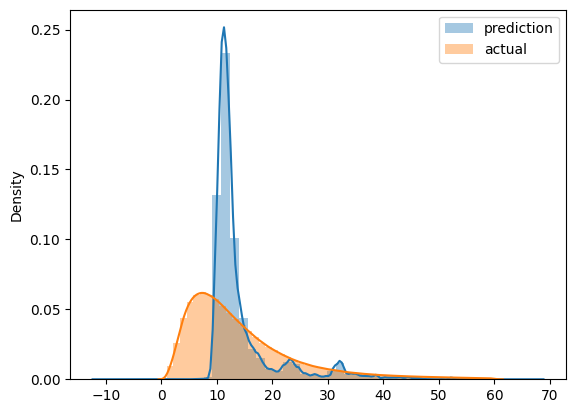

In [151]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [152]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [153]:
df_train = read_dataframe('/local/repo/mlops/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('/local/repo/mlops/yellow_tripdata_2023-02.parquet')

In [154]:
len(df_train), len(df_val)

(3009173, 2855951)

In [155]:
# df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
# df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [156]:
categorical = ['PULocationID', 'DOLocationID']#'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [157]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.820139417466039

In [159]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [160]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)



8.137900681701906